# **Imports**

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
# representation of model layers
from keras.utils.vis_utils import plot_model

## Reading Data

In [2]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

train='./nslkdd/KDDTrain+.txt'
test='./nslkdd/KDDTest+.txt'
test21='./nslkdd/KDDTest-21.txt'
train_data=pd.read_csv(train,names=feature)
test_data=pd.read_csv(test,names=feature)
test_data21 = pd.read_csv(test21, names= feature)
data= pd.concat([train_data, test_data], ignore_index=True)
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148513,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148514,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15
148515,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [3]:
# remove attribute 'difficulty_level'
data.drop(['difficulty'],axis=1,inplace=True)

## Exploring Data

In [4]:
# Redistribute across common attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

change_label(data)
data.label.value_counts()
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,smtp,SF,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal
148513,0,tcp,http,SF,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal
148514,0,tcp,http,SF,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,Dos
148515,0,udp,domain_u,SF,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal


### Protocol

In [5]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(data.label)
label

,label
0,normal
1,normal
2,Dos
3,normal
4,normal
...,...
148512,normal
148513,normal
148514,Dos
148515,normal


In [6]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = data.select_dtypes(include='number').columns
data = standardization(data,numeric_col)
data


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.849240,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,normal
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.065006,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.840250,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,Dos
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,normal
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,0.193625,0.413961,-0.124178,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal
148513,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal
148514,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,1.218511,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.205182,-0.198035,Dos
148515,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,1.191540,1.016560,-0.381775,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal


In [7]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)
data

(148517, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,normal,4
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,Dos,0
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,normal,4
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,0.413961,-0.124178,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal,4
148513,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal,4
148514,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.205182,-0.198035,Dos,0
148515,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,1.016560,-0.381775,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4


In [8]:
data.drop(labels= ['label'], axis=1, inplace=True)
print(data.shape)


(148517, 42)


In [9]:
# one-hot-encoding categorical columns
data = pd.get_dummies(data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  
print(data.shape)

(148517, 123)


In [10]:
y_data= data['intrusion']
X_data= data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_data.shape,'\ny_train has shape:',y_data.shape)

X_train has shape: (148517, 122) 
y_train has shape: (148517,)


In [11]:
from sklearn.preprocessing import LabelBinarizer
y_data = LabelBinarizer().fit_transform(y_data)

X_data=np.array(X_data)
y_data=np.array(y_data)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=42)
print(X_train.shape,'\n',X_test.shape)

(118813, 122) 
 (29704, 122)


In [13]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))

In [14]:
model = Sequential() # initializing model
model.add(LSTM(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

In [15]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# summary of model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             47872     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             33024     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3

In [17]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 16s 216ms/step - loss: 1.5095 - accuracy: 0.5793 - val_loss: 1.3139 - val_accuracy: 0.7560
Epoch 2/100
20/20 [==============================] - 3s 132ms/step - loss: 0.9629 - accuracy: 0.8162 - val_loss: 0.5656 - val_accuracy: 0.8374
Epoch 3/100
20/20 [==============================] - 3s 129ms/step - loss: 0.4624 - accuracy: 0.8449 - val_loss: 0.3943 - val_accuracy: 0.8561
Epoch 4/100
20/20 [==============================] - 3s 130ms/step - loss: 0.3662 - accuracy: 0.8910 - val_loss: 0.3287 - val_accuracy: 0.9165
Epoch 5/100
20/20 [==============================] - 3s 126ms/step - loss: 0.2957 - accuracy: 0.9241 - val_loss: 0.2482 - val_accuracy: 0.9357
Epoch 6/100
20/20 [==============================] - 3s 132ms/step - loss: 0.2202 - accuracy: 0.9382 - val_loss: 0.1899 - val_accuracy: 0.9439
Epoch 7/100
20/20 [==============================] - 3s 150ms/step - loss: 0.1810 - accuracy: 0.9441 - val_loss: 0.1636 - val_accuracy: 0.947

KeyboardInterrupt: 

In [ ]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 [==============================] - 3s 3ms/step - loss: 0.0376 - accuracy: 0.9884
Test results - Loss: 0.037623848766088486 - Accuracy: 98.83853793144226%


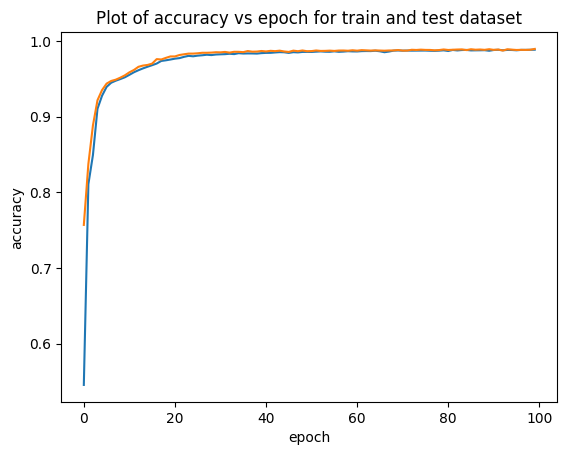

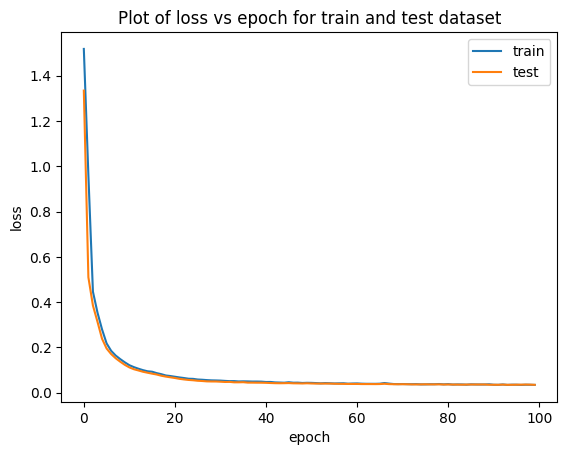

In [ ]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

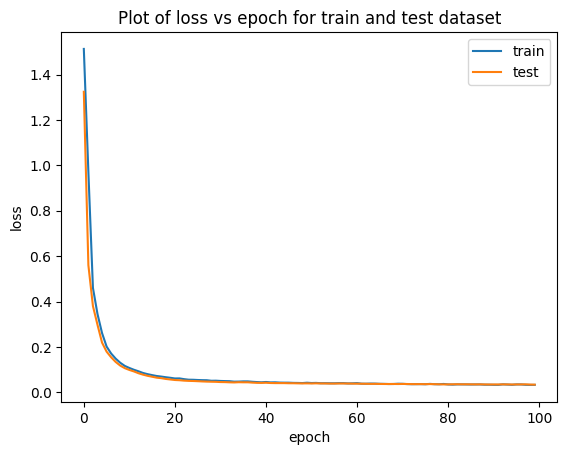